# pdfplumber

本 Notebook 主要内容如下：

- 加载PDF文件
- 提取单页文本
- 提取单页表格
- 可视化调试页面
- 提取页面图像

## 加载PDF文件

要开始处理PDF，请调用`pdfplumber.open(x)`方法，其中`x`可以是：

- PDF 文件路径
- 作为字节加载的文件对象
- 作为字节加载的类似文件的对象

open方法将返回一个`pdfplumber.PDF`类的实例。

### 高级加载参数

要加载受密码保护的PDF，请传递`password`关键字参数，例如：`pdfplumber.open("file.pdf", password="test")`。

要设置布局分析参数到`pdfminer.six`的布局引擎中，请传递`laparams`关键字参数，例如：`pdfplumber.open("file.pdf", laparams={"line_overlap": 0.7})`。

### pdfplumber.PDF 类

`pdfplumber.PDF`类表示一个独立的PDF文件，两个主要成员变量：

- `.metadata`：一个由PDF的 `Info` 尾部信息中的元数据键/值对组成的字典。通常包括 "CreationDate," "ModDate," "Producer," 等等。
- `.pages`：包含每个已加载页面的 `pdfplumber.Page` 实例的列表。

一个主要成员方法：

- `.close()`：默认情况下，`Page` 对象会缓存其布局和对象信息，以避免重新处理。然而，在解析大型PDF时，这些缓存的属性可能需要大量内存。你可以使用此方法来清除缓存并释放内存。（在 `<= 0.5.25` 版本中，使用 `.flush_cache()`。）

In [2]:
import pdfplumber

pdf = pdfplumber.open("data/The_Old_Man_of_the_Sea.pdf")

pdf.metadata

{'CreationDate': "D:20060717205532+08'00'",
 'Subject': 'For Personal Learning!',
 'Author': 'Asiaing.com',
 'Creator': 'PScript5.dll Version 5.2',
 'Producer': 'Acrobat Distiller 7.0.5 (Windows)',
 'ModDate': "D:20060717210222+08'00'",
 'Title': 'Hemingway, Ernest - The Old Man and the Sea'}

In [3]:
pdf.pages

[<Page:1>,
 <Page:2>,
 <Page:3>,
 <Page:4>,
 <Page:5>,
 <Page:6>,
 <Page:7>,
 <Page:8>,
 <Page:9>,
 <Page:10>,
 <Page:11>,
 <Page:12>,
 <Page:13>,
 <Page:14>,
 <Page:15>,
 <Page:16>,
 <Page:17>,
 <Page:18>,
 <Page:19>,
 <Page:20>,
 <Page:21>,
 <Page:22>,
 <Page:23>,
 <Page:24>,
 <Page:25>,
 <Page:26>,
 <Page:27>,
 <Page:28>,
 <Page:29>,
 <Page:30>,
 <Page:31>,
 <Page:32>,
 <Page:33>,
 <Page:34>,
 <Page:35>,
 <Page:36>,
 <Page:37>,
 <Page:38>,
 <Page:39>,
 <Page:40>,
 <Page:41>,
 <Page:42>,
 <Page:43>,
 <Page:44>,
 <Page:45>,
 <Page:46>,
 <Page:47>,
 <Page:48>,
 <Page:49>,
 <Page:50>,
 <Page:51>,
 <Page:52>]

In [4]:
type(pdf.pages[0])

pdfplumber.page.Page

## pdfplumber.Page 类

`pdfplumber.Page` 类是 `pdfplumber` 的核心，表示PDF文件中一页单独的内容。当我们使用 `pdfplumber` 时，大部分操作都会围绕这个类展开。主要成员变量如下：

- `.page_number`：顺序页码，从第一页开始为 `1`，第二页为 `2`，以此类推。
- `.width`：页面的宽度。
- `.height`：页面的高度。
- `.objects` / `.chars` / `.lines` / `.rects` / `.curves` / `.images`：这些属性都是列表，每个列表包含页面上嵌入的每个此类对象的一个字典。

In [5]:
pdf = pdfplumber.open("data/test.pdf")
pages = pdf.pages
print(pages)

[<Page:1>, <Page:2>]


In [6]:
pages[0].page_number

1

In [7]:
print(pages[0].width, pages[0].height)

595 842


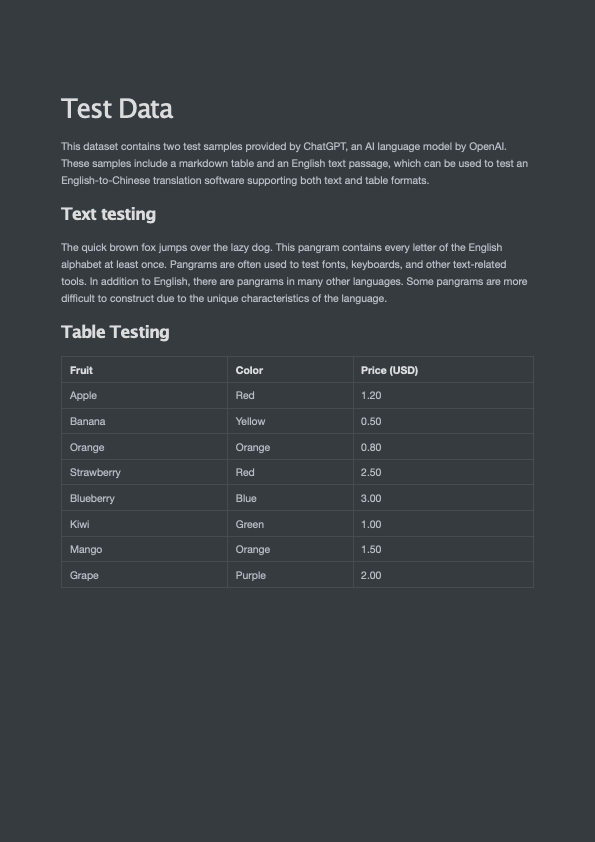

In [8]:
# 可视化第1页
pages[0].to_image()

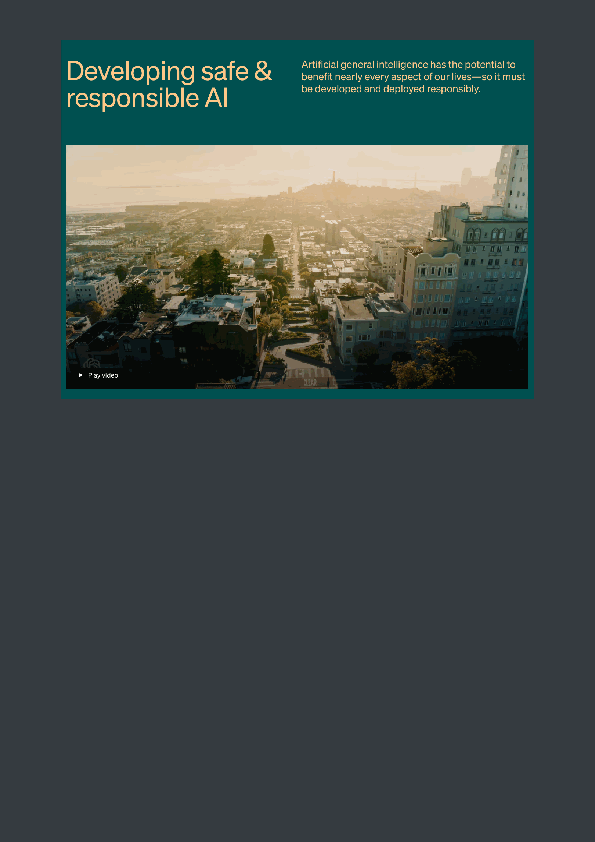

In [9]:
# 可视化第2页（尝试调整分辨率和抗锯齿）
pages[1].to_image()

## 提取单页文本

`pdfplumber`库支持从任何给定的页面(`pdfplumber.Page`)中提取文本（包括裁剪和派生页面）。在提取文本的基础功能外，同时支持保留文本布局，识别单词和搜索页面中的文本

### 文本提取方法

`pdfplumber.Page` 对象可以调用以下方法：
- `.extract_text(x_tolerance=3, y_tolerance=3, layout=False, x_density=7.25, y_density=13, **kwargs)`：将页面的所有字符对象汇集成一个单一的字符串。<ul><li><p>当 `layout=False` 时：在一个字符的 `x1` 和下一个字符的 `x0` 之间的差异大于 `x_tolerance` 时添加空格。在一个字符的 `doctop` 和下一个字符的 `doctop` 之间的差异大于 `y_tolerance` 时添加换行符。</p></li><li><p>当 `layout=True`（*实验性功能*）时：尝试模仿页面上文本的结构布局，使用 `x_density` 和 `y_density` 来确定每个"点"（PDF的度量单位）的最小字符/换行符数量。所有剩余的 `**kwargs` 都传递给 `.extract_words(...)`（见下文），这是计算布局的第一步。</p></li></ul>
- `.extract_text_simple(x_tolerance=3, y_tolerance=3)`：`.extract_text(...)` 的稍快但不太灵活的版本，使用更简单的逻辑。
- `.extract_words(x_tolerance=3, y_tolerance=3, keep_blank_chars=False, use_text_flow=False, horizontal_ltr=True, vertical_ttb=True, extra_attrs=[], split_at_punctuation=False, expand_ligatures=True)`：返回所有看起来像单词的东西及其边界框的列表。单词被认为是字符序列，其中（对于"直立"字符）一个字符的 `x1` 和下一个字符的 `x0` 之间的差异小于或等于 `x_tolerance` *并且* 一个字符的 `doctop` 和下一个字符的 `doctop` 之间的差异小于或等于 `y_tolerance`。对于非直立字符，采取类似的方法，但是测量它们之间的垂直距离，而不是水平距离。参数 `horizontal_ltr` 和 `vertical_ttb` 表示是否应从左到右阅读单词（对于水平单词）/从上到下（对于垂直单词）。将 `keep_blank_chars` 更改为 `True` 将意味着空白字符被视为单词的一部分，而不是单词之间的空格。将 `use_text_flow` 更改为 `True` 将使用PDF的底层字符流作为排序和划分单词的指南，而不是预先按x/y位置排序字符。（这模仿了在PDF中拖动光标突出显示文本的方式；就像那样，顺序并不总是看起来逻辑。）传递 `extra_attrs` 列表（例如，`["fontname", "size"]` 将限制每个单词的字符具有完全相同的值，对于这些[属性](#char-properties)，并且结果的单词dicts将指示这些属性。将 `split_at_punctuation` 设置为 `True` 将在 `string.punctuation` 指定的标点处强制分割标记；或者你可以通过传递一个字符串来指定分隔标点的列表，例如，<code>split_at_punctuation='!"&\'()*+,.:;<=>?@[\]^\`\{\|\}~'</code>。除非你设置 `expand_ligatures=False`，否则将展开诸如 `ﬁ` 之类的连字成其组成字母（例如，`fi`）。
- `.extract_text_lines(layout=False, strip=True, return_chars=True, **kwargs)`：*实验性功能*，返回代表页面上文本行的字典列表。`strip` 参数类似于Python的 `str.strip()` 方法，并返回没有周围空白的 `text` 属性。（只有当 `layout = True` 时才相关。）将 `return_chars` 设置为 `False` 将排除从返回的文本行dicts中添加单个字符对象。剩余的 `**kwargs` 是你将传递给 `.extract_text(layout=True, ...)` 的参数。
- `.search(pattern, regex=True, case=True, main_group=0, return_groups=True, return_chars=True, layout=False, **kwargs)`：*实验性功能*，允许你搜索页面的文本，返回匹配查询的所有实例的列表。对于每个实例，响应字典对象包含匹配的文本、任何正则表达式组匹配、边界框坐标和字符对象本身。`pattern` 可以是编译的正则表达式、未编译的正则表达式或非正则字符串。如果 `regex` 是 `False`，则将模式视为非正则字符串。如果 `case` 是 `False`，则以不区分大小写的方式执行搜索。设置 `main_group` 将结果限制为 `pattern` 中的特定正则组（`0` 的默认值表示整个匹配）。将 `return_groups` 和/或 `return_chars` 设置为 `False` 将排除添加匹配的正则组和/或字符的列表（作为 `"groups"` 和 `"chars"` 添加到返回的dicts）。`layout` 参数的操作方式与 `.extract_text(...)` 相同。剩余的 `**kwargs` 是你将传递给 `.extract_text(layout=True, ...)` 的参数。 __注意__：零宽度和全空白匹配被丢弃，因为它们（通常）在页面上没有明确的位置。
- `.dedupe_chars(tolerance=1)`：返回页面的版本，其中删除了重复的字符 — 那些与其他字符共享相同的文本、字体名、大小和位置（在 `tolerance` x/y 内）的字符。


In [10]:
# 获取单页文本
p1_text = pages[0].extract_text()
print(p1_text)

Test Data
This dataset contains two test samples provided by ChatGPT, an AI language model by OpenAI.
These samples include a markdown table and an English text passage, which can be used to test an
English-to-Chinese translation software supporting both text and table formats.
Text testing
The quick brown fox jumps over the lazy dog. This pangram contains every letter of the English
alphabet at least once. Pangrams are often used to test fonts, keyboards, and other text-related
tools. In addition to English, there are pangrams in many other languages. Some pangrams are more
difficult to construct due to the unique characteristics of the language.
Table Testing
Fruit Color Price (USD)
Apple Red 1.20
Banana Yellow 0.50
Orange Orange 0.80
Strawberry Red 2.50
Blueberry Blue 3.00
Kiwi Green 1.00
Mango Orange 1.50
Grape Purple 2.00


In [11]:
# 获取单页文本（保留布局），表格也被文本解析出来了
p1_text = pages[0].extract_text(layout=True)
print(p1_text)

                                                                                  
                                                                                  
                                                                                  
                                                                                  
                                                                                  
                                                                                  
                                                                                  
        Test    Data                                                              
                                                                                  
                                                                                  
                                                                                  
        This dataset contains two test samples provided by ChatGPT, an AI language mode

### 提取单页表格

`pdfplumber` 对表格提取的方法大量借鉴了 [Anssi Nurminen 的硕士论文](http://dspace.cc.tut.fi/dpub/bitstream/handle/123456789/21520/Nurminen.pdf?sequence=3)，并受到 [Tabula](https://github.com/tabulapdf/tabula-extractor/issues/16) 的启发。它的工作原理如下：

1. 对于任何给定的PDF页面，找到那些（a）明确定义的线条和/或（b）由页面上单词的对齐方式暗示的线条。
2. 合并重叠的，或几乎重叠的，线条。
3. 找到所有这些线条的交点。
4. 找到使用这些交点作为顶点的最精细的矩形集合（即，单元格）。
5. 将连续的单元格分组成表格。

#### 表格提取方法

`pdfplumber.Page` 对象可以调用以下方法：
- `.find_tables(table_settings={})`：返回一个 `Table` 对象的列表。`Table` 对象提供对 `.cells`，`.rows`，和 `.bbox` 属性的访问，以及 `.extract(x_tolerance=3, y_tolerance=3)` 方法。
-`.find_table(table_settings={})`：类似于 `.find_tables(...)`，但返回页面上 *最大* 的表格，作为一个 `Table` 对象。如果多个表格的大小相同 —— 以单元格数量衡量 —— 此方法返回最接近页面顶部的表格。
- `.extract_tables(table_settings={})`：返回从页面上找到的 *所有* 表格中提取的文本，表示为一个列表的列表的列表，结构为 `table -> row -> cell`。
- `.extract_table(table_settings={})`：返回从页面上 *最大* 的表格中提取的文本（参见上面的 `.find_table(...)`），表示为一个列表的列表，结构为 `row -> cell`。
- `.debug_tablefinder(table_settings={})`：返回 `TableFinder` 类的一个实例，可以访问 `.edges`，`.intersections`，`.cells`，和 `.tables` 属性。

In [12]:
# 获取单页表格
p1_table = pages[0].extract_table()
p1_table

[['Fruit', 'Color', 'Price (USD)'],
 ['Apple', 'Red', '1.20'],
 ['Banana', 'Yellow', '0.50'],
 ['Orange', 'Orange', '0.80'],
 ['Strawberry', 'Red', '2.50'],
 ['Blueberry', 'Blue', '3.00'],
 ['Kiwi', 'Green', '1.00'],
 ['Mango', 'Orange', '1.50'],
 ['Grape', 'Purple', '2.00']]

In [14]:
# 获取单页所有表格
tables = pages[0].extract_tables()
len(tables)

1

In [15]:
tables

[[['Fruit', 'Color', 'Price (USD)'],
  ['Apple', 'Red', '1.20'],
  ['Banana', 'Yellow', '0.50'],
  ['Orange', 'Orange', '0.80'],
  ['Strawberry', 'Red', '2.50'],
  ['Blueberry', 'Blue', '3.00'],
  ['Kiwi', 'Green', '1.00'],
  ['Mango', 'Orange', '1.50'],
  ['Grape', 'Purple', '2.00']]]

In [16]:
p1_debug_table = pages[0].debug_tablefinder()
type(p1_debug_table)

pdfplumber.table.TableFinder

In [17]:
p1_debug_table.tables

#### 使用 Pandas.DataFrame 来展示和存储表格

In [18]:
import pandas as pd

df = pd.DataFrame(p1_table[1:], columns=p1_table[0])
df

,Fruit,Color,Price (USD)
0,Apple,Red,1.20
1,Banana,Yellow,0.50
2,Orange,Orange,0.80
3,Strawberry,Red,2.50
4,Blueberry,Blue,3.00
5,Kiwi,Green,1.00
6,Mango,Orange,1.50
7,Grape,Purple,2.00


### 可视化调试页面

`pdfplumber` 可视化调试工具可以帮助我们理解PDF文件的内容和结构，以及从中提取出来的对象。

#### `PageImage` 类

`pdfplumber.Page` 对象可以使用`.to_image()`方法，将任何页面（包括裁剪后的页面）转换为`PageImage`对象。`pdfplumber.Page.to_image()`方法主要参数：

- resolution：所需每英寸像素数。默认值：72。类型：整数。
- width：所需图像宽度（以像素为单位）。默认值：未设置，由分辨率确定。类型：整数。
- height：所需图像高度（以像素为单位）。默认值：未设置，由分辨率确定。类型：整数。
- antialias: 是否在创建图像时使用抗锯齿。将其设置为True可以创建具有较少锯齿的文本和图形，但文件大小会更大。默认值：False。类型：布尔值。

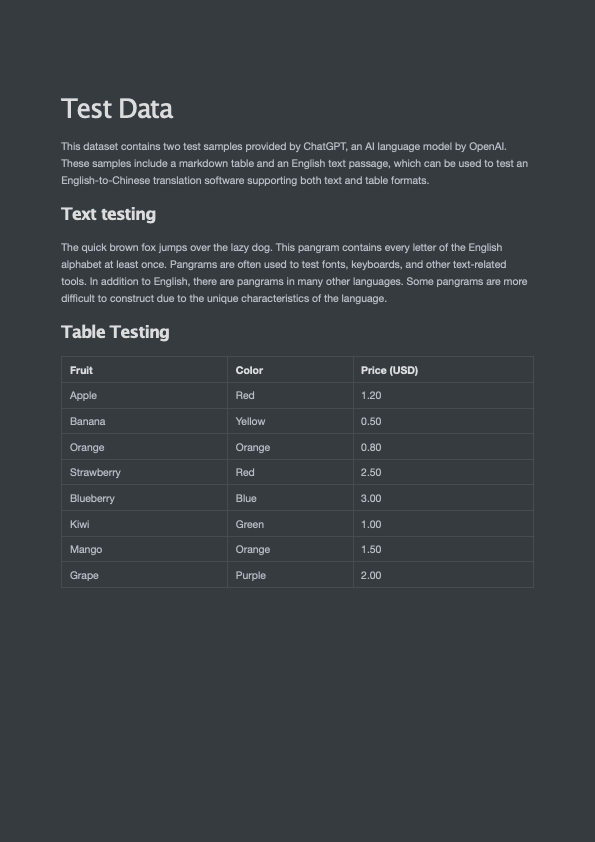

In [19]:
# 可视化第一页
pages[0].to_image()

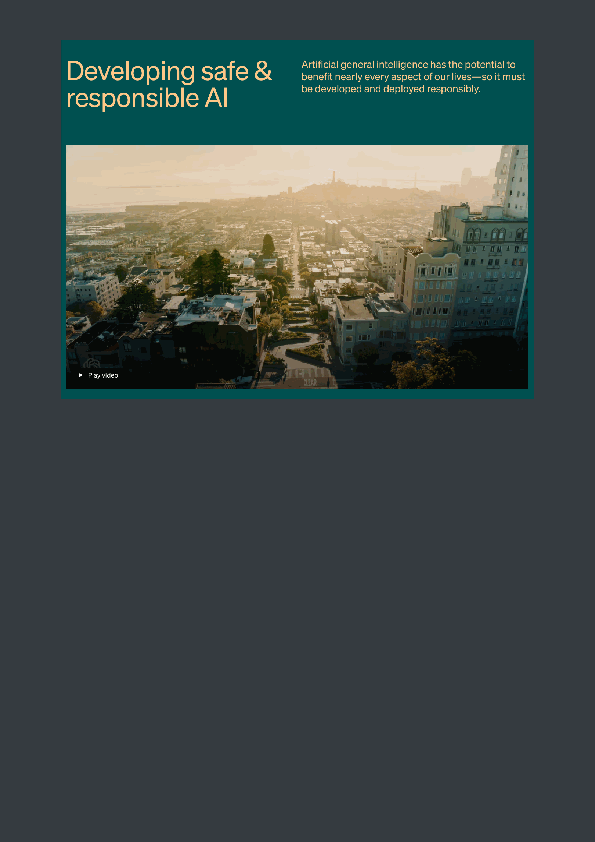

In [20]:
# 可视化第二页（尝试调整分辨率和抗锯齿）
pages[1].to_image()

### 提取页面图像

`pdfplumber.Page` 对象没有 extract_images 方法，所以不能直接从 PDF 页面中提取图像。但是，可以通过页面操作来截取和获取图像，`pdfplumber.Page`类相关成员变量如下：
- `.width`：页面的宽度。
- `.height`：页面的高度。
- `.objects` / `.chars` / `.lines` / `.rects` / `.curves` / `.images`：这些属性都是列表，每个列表包含页面上嵌入的每个此类对象的一个字典。

相关成员方法：
- `.crop(bounding_box, relative=False, strict=True)`：返回裁剪到边界框的页面版本，边界框应表示为4元组，值为 `(x0, top, x1, bottom)`。裁剪的页面保留至少部分在边界框内的对象。如果对象只部分在框内，其尺寸将被切割以适应边界框。如果 `relative=True`，则边界框是从页面边界框的左上角偏移计算的，而不是绝对定位。当 `strict=True`（默认值）时，裁剪的边界框必须完全在页面的边界框内。
- `.within_bbox(bounding_box, relative=False, strict=True)`：类似于 `.crop`，但只保留 *完全在* 边界框内的对象。
- `.outside_bbox(bounding_box, relative=False, strict=True)`：类似于 `.crop` 和 `.within_bbox`，但只保留 *完全在* 边界框外的对象。
- `.filter(test_function)`：返回只有 `test_function(obj)` 返回 `True` 的 `.objects` 的页面版本。

In [21]:
# 从 PageImage 中获取页面图像分辨率
pages[1].images

[{'x0': 61.25348,
  'y0': 443.9213,
  'x1': 533.74648,
  'y1': 801.8948,
  'width': 472.493,
  'height': 357.97350000000006,
  'stream': <PDFStream(17): raw=1522591, {'Type': /'XObject', 'Subtype': /'Image', 'Width': 1288, 'Height': 975, 'Interpolate': True, 'ColorSpace': <PDFObjRef:18>, 'Intent': /'Perceptual', 'BitsPerComponent': 8, 'Length': 1522590, 'Filter': /'FlateDecode'}>,
  'srcsize': (1288, 975),
  'imagemask': None,
  'bits': 8,
  'colorspace': [[/'ICCBased',
    <PDFStream(19): raw=2758, {'N': 3, 'Alternate': /'DeviceRGB', 'Length': 2757, 'Filter': /'FlateDecode'}>]],
  'mcid': None,
  'tag': None,
  'object_type': 'image',
  'page_number': 2,
  'top': 40.10519999999997,
  'bottom': 398.0787,
  'doctop': 882.1052}]

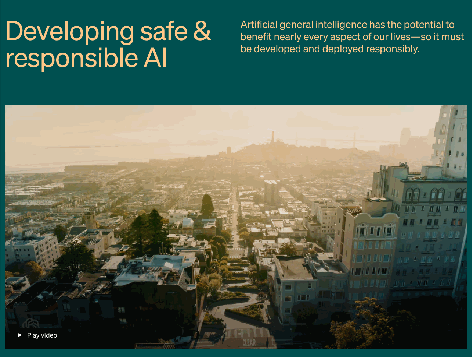

In [22]:
img = pages[1].images[0]
bbox = (img["x0"], img["top"], img["x1"], img["bottom"])
cropped_page = pages[1].crop(bbox)
cropped_page.to_image()

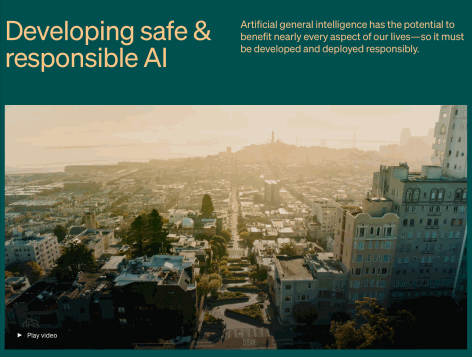

In [23]:
# 可视化裁剪后的第二页+抗锯齿
cropped_page.to_image(antialias=True)

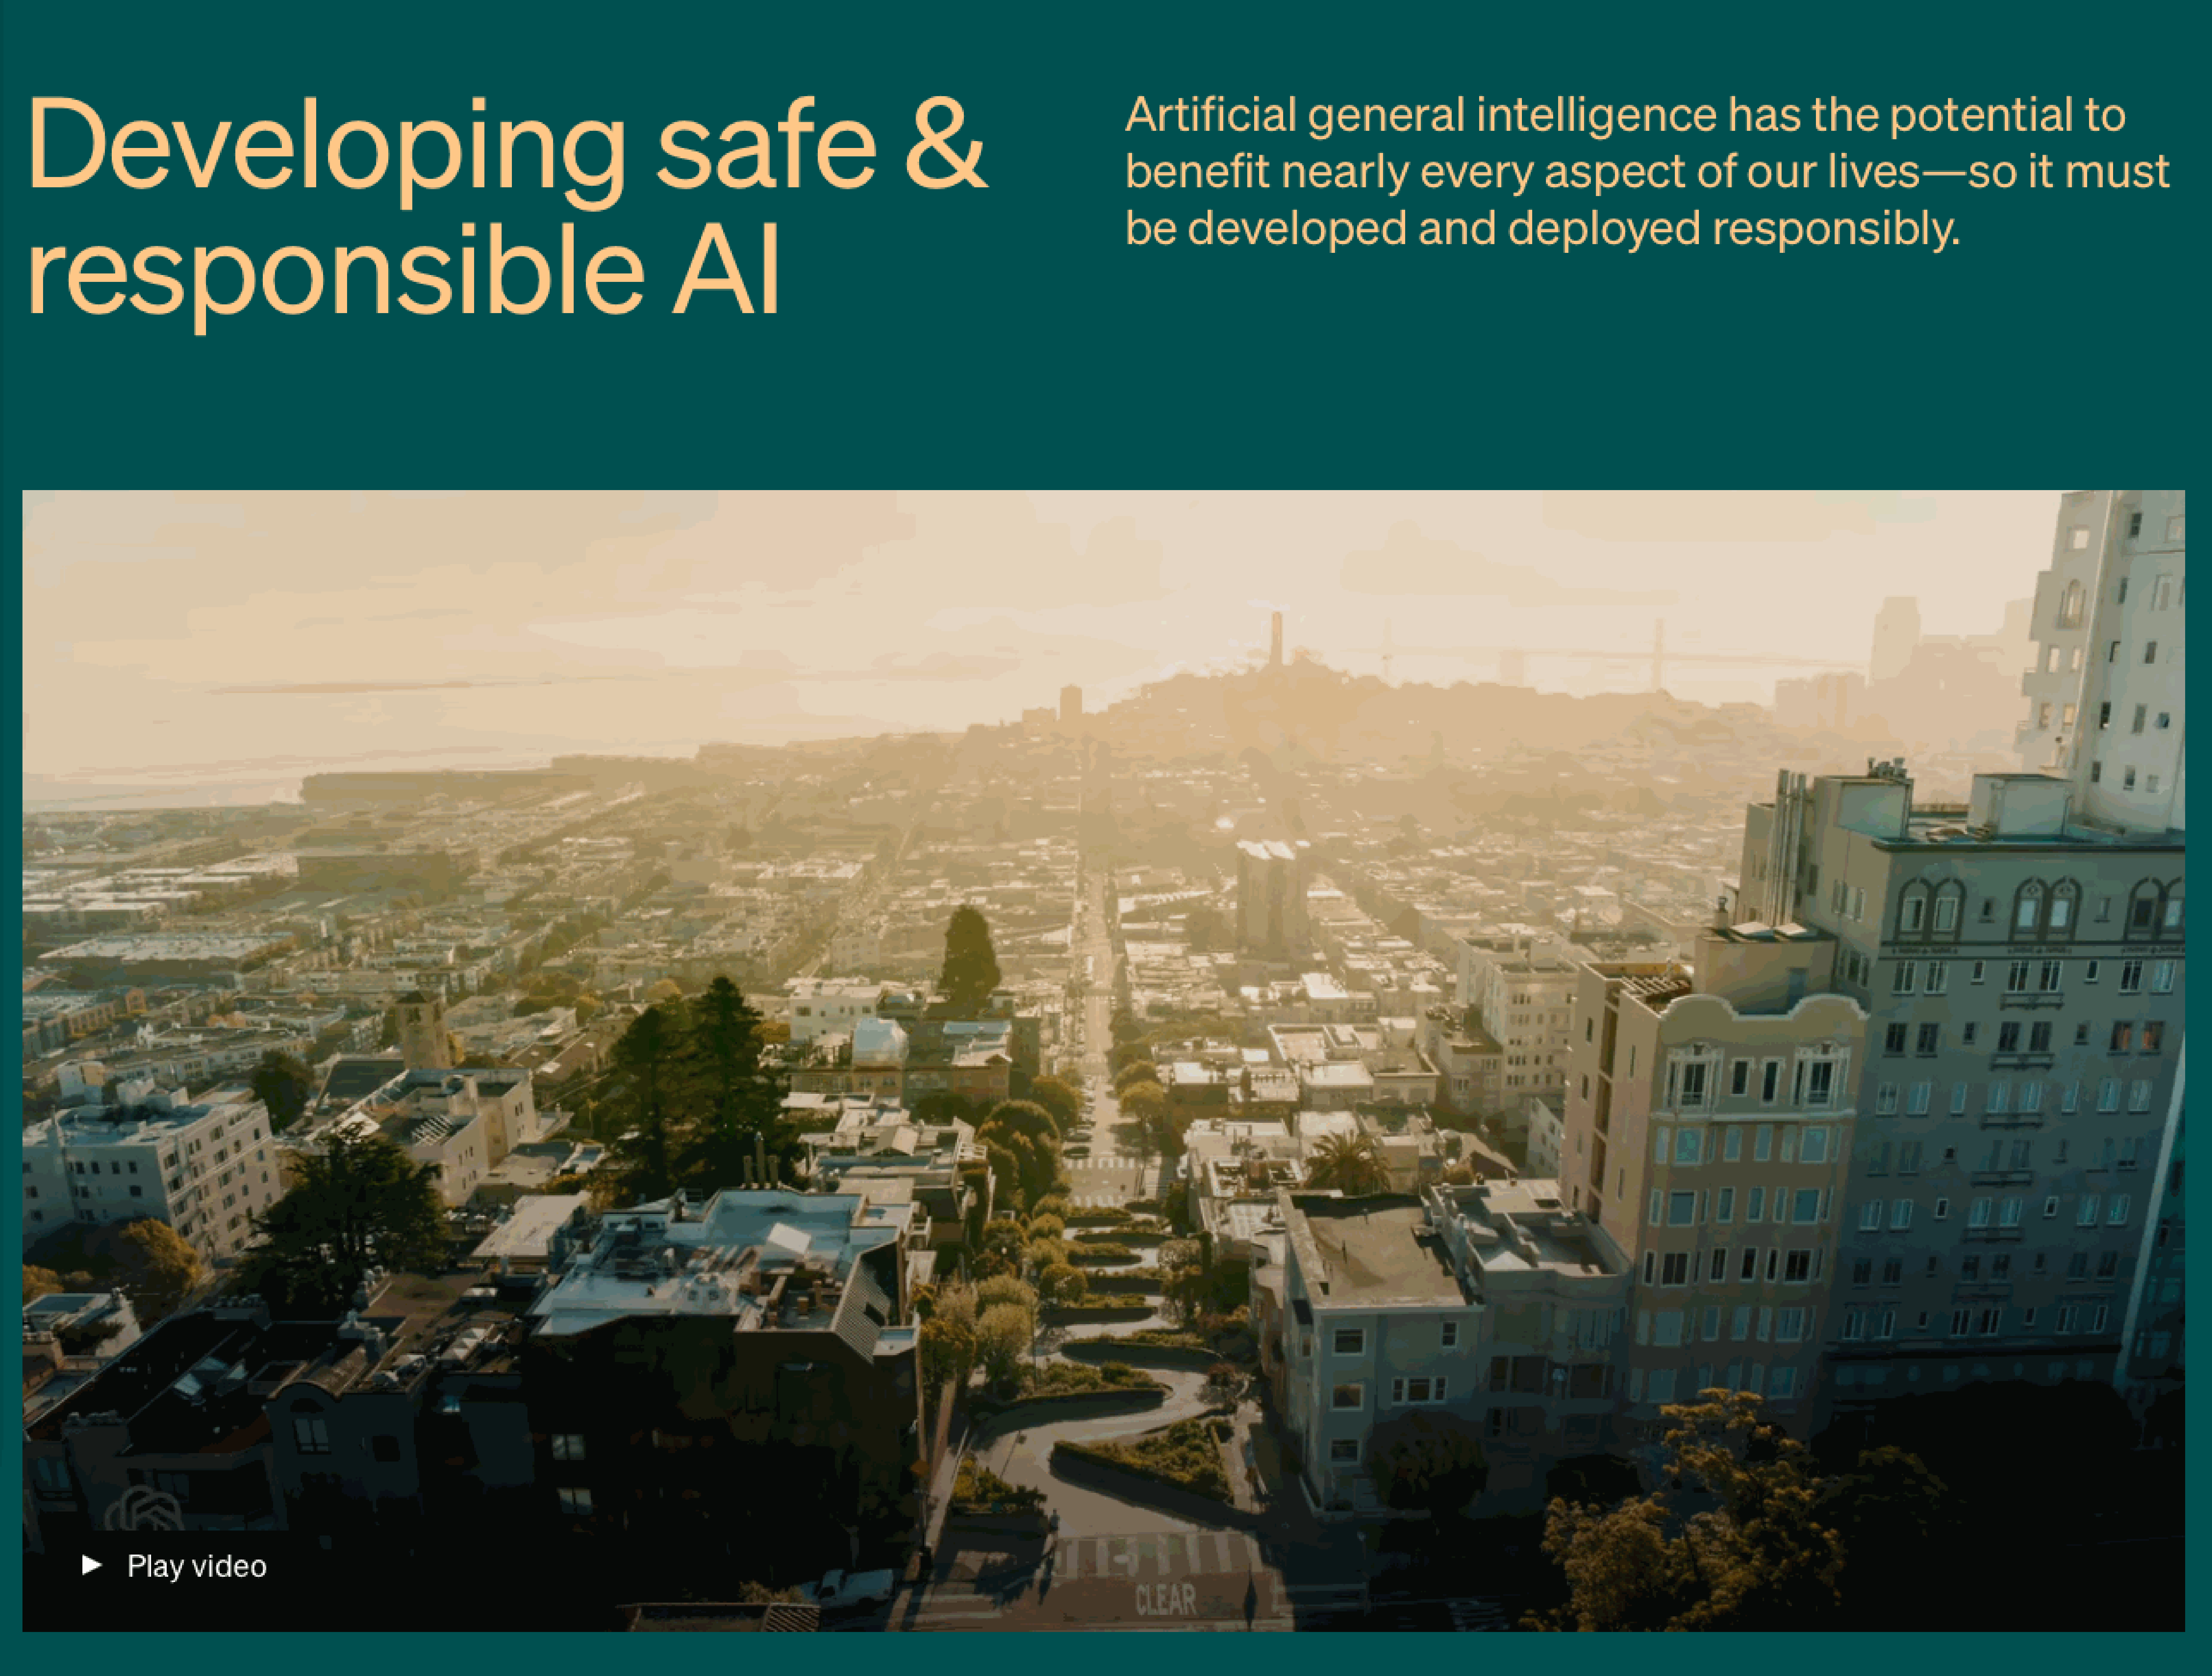

In [24]:
cropped_page.to_image(resolution=1080)

In [25]:
im = cropped_page.to_image(antialias=True)
im.save("pdf_image_test.png")